In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import h5py
import matplotlib.lines as mlines

In [2]:
sns.set()

In [41]:
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties

In [4]:
from Functions import position_gene, NFR_position

# Studying the mutazome

### Comparison with NFR position

The first study of the nucleazome is to represent it and the NFR position to see weither there is a match between high effect of mutations and being in NFR position.
Plotting the mean value of the nucleazome around NFR positions can help assessing this effect.

In [88]:
mutation_map = np.load('../Results_nucleosome/mutazome_2001.npy')

In [6]:
# Gene position in S.cerevisiae chromosome 16.
position = pd.read_table('./Start_data/position_genes.txt', sep = '\t')
position.head()

,Chr,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,Protein name
0,XVI,NC_001148.4,280,6007,-,855846,YRF1-7,YPL283C,NP_015040.1,1859,Y\' element ATP-dependent helicase protein 1 c...
1,XVI,NC_001148.4,7933,8427,-,855847,PAU22,YPL282C,NP_015041.1,164,seripauperin PAU22
2,XVI,NC_001148.4,9557,10870,-,855848,ERR2,YPL281C,NP_015042.1,437,phosphopyruvate hydratase ERR2
3,XVI,NC_001148.4,11887,12600,+,855849,HSP32,YPL280W,NP_015043.1,237,glutathione-independent methylglyoxalase famil...
4,XVI,NC_001148.4,13228,14355,-,855850,FEX2,YPL279C,NP_015044.1,375,fluoride transporter


In [7]:
# We import the experimental landscape of nucleosome on chromosome 16 of S.cerevisiae to find the NFR.
WINDOW = 2001
HALF_WX = WINDOW // 2

proba = pd.read_csv('./Start_data/proba_normalized.csv')
y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]

In [9]:
# Calculing the NFR position on chromosome 16 
nfr_position = NFR_position(y_true, HALF_WX, position)
nfr_start = nfr_position[nfr_position.strand == '+'].nfr_pos.values + HALF_WX
nfr_stop = nfr_position[nfr_position.strand == '-'].nfr_pos.values + HALF_WX
nfr_position = nfr_position.nfr_pos.values # offset between mutazome and y_pred

<IPython.core.display.Javascript object>


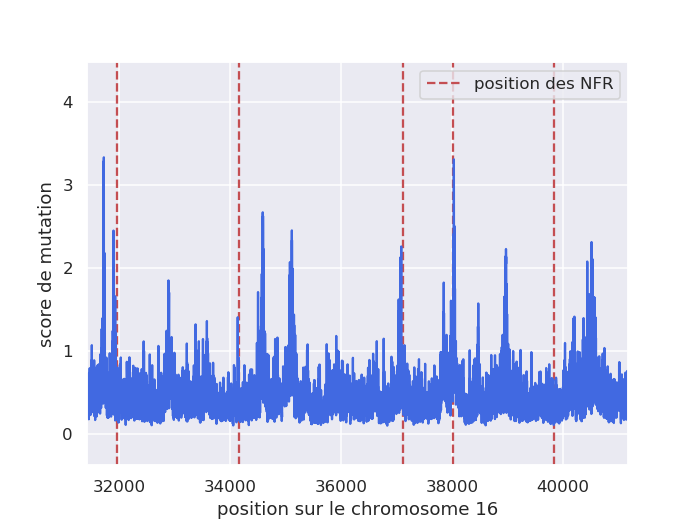

[Text(0,0.5,'score de mutation'), Text(0.5,0,'position sur le chromosome 16')]

In [34]:
fig = plt.figure()

ax = plt.axes()
#plt.title('Muteazome on chr16 of S.cerevisiae')
for xc in nfr_position:
    plt.axvline(x=xc, color='r', linestyle='--')
ax.plot(np.sum(mutation_map, axis=1), color='royalblue')
ax.legend(handles=[mlines.Line2D([], [], color='r', markersize=15, linestyle='--', label="position des NFR")])
ax.set(xlabel='position sur le chromosome 16', ylabel='score de mutation')

<IPython.core.display.Javascript object>


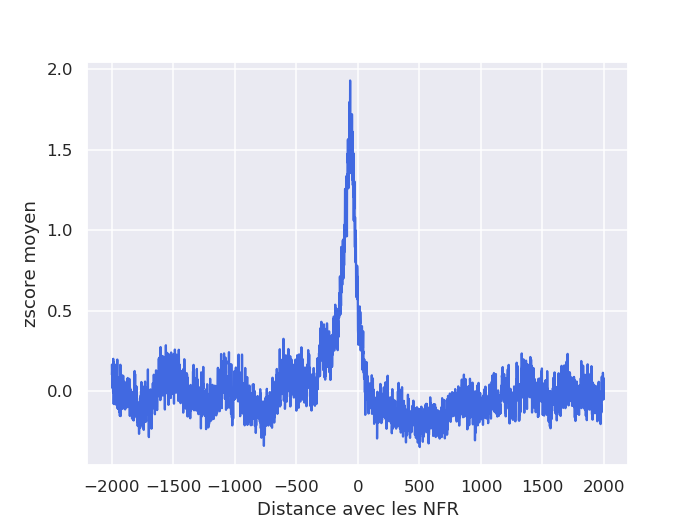

[Text(0,0.5,'zscore moyen'), Text(0.5,0,'Distance avec les NFR')]

In [35]:
WX = 2000

z_score = np.sum(mutation_map[:205000], axis=1)
z_score = z_score - np.mean(z_score)
z_score /= np.std(z_score)

nfr_region_start = np.array([z_score[pos - WX : pos + WX] for pos in nfr_start[nfr_start < 200000]])
nfr_region_stop = np.array([z_score[pos - WX : pos + WX][::-1] for pos in nfr_stop[nfr_stop < 200000]])
nfr_region = np.append(nfr_region_start, nfr_region_stop, axis=0)

fig = plt.figure()
ax = plt.axes()
plt.plot(range(- WX, WX), np.mean(nfr_region, axis=0), color='royalblue')
#plt.title('Zscore moyen autour des NFR')
ax.set(xlabel='Distance avec les NFR', ylabel='zscore moyen')

Those peaks at +/- 2000 bp from the NFR position are strange and we plot the autocorrelation of the mutazome to see if there is such a periodicity in it.

In [ ]:
plt.plot([pearsonr(z_score[i:], z_score[:-i])[0] for i in range(1, 3000)])

### Important motives in nucleosome positioning

In [17]:
f = h5py.File('./seq_chr_sacCer3/sacCer3/chr16.hdf5',
              'r')
nucleotid = np.array(f[f.keys()[0]])
f.close()
nucleotid = nucleotid[:,0]

In [18]:
mutation_peaks = np.where(z_score > 3.5)[0]
mutation_peaks.shape

(2687,)

In [20]:
motives = np.array([nucleotid[peak - 2 : peak + 3] for peak in mutation_peaks])
motives, counts = np.unique(motives, axis=0, return_counts=True)

counts = counts[np.argsort(counts)][::-1]
motives = motives[np.argsort(counts)][::-1]

In [54]:
fp = FontProperties(family="Arial", weight="bold") 
globscale = 1.35
LETTERS = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }
COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen'}

def _letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def plot_logo(motif):
    """
        Plot a logo associated to a motif, the motif must be a numpy array with 1 standing for A, 2 for T, 3 for G
        and 4 for C.
    """
    motif = (np.arange(4) == motif[...,None]-1).astype(int)
    motif = motif.reshape((motif.shape[0], 4))

    fig, ax = plt.subplots(figsize=(5,2))
    all_scores = [[('A', motif[i, 0]),
                   ('T', motif[i, 1]),
                   ('G', motif[i, 2]),
                   ('C', motif[i, 3])] for i in range(motif.shape[0])]

    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            _letterAt(base, x,y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    plt.xticks(range(1,x))
    plt.xlim((0, x)) 
    plt.ylim((0, maxi)) 
    plt.tight_layout()      
    plt.show()

/users/invites/routhier/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/invites/routhier/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/invites/routhier/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/invites/routhier/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext

<IPython.core.display.Javascript object>


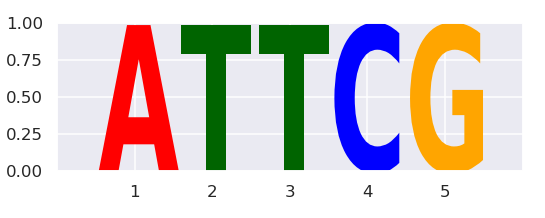

In [83]:
plot_logo(motives[29])

#### Experimental p-value

In [81]:
p_value = np.zeros(counts.shape)
TRIES = 1000
N = mutation_peaks.shape[0]
k = -1

for motif, count in zip(motives, counts):
    k += 1
    for _ in range(TRIES):
        rand_motives = np.array([nucleotid[i - 2 : i + 3] for i in np.random.randint(3, nucleotid.shape[0] - 3, N)])
        indexes = np.arange(N)[[(rand_motives[j] == motif).all() for j in range(N)]]

        if len(indexes) >= count:
            p_value[k] += 1

print(p_value)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   0.
 114.   0.   0.   0.   0.   0.   6.   3.   0.   0.   0.   0.   0.   0.
   5.  71.   0.   0.   0.  12.   0.   0.   0.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 329.   0.   0.   0.   0.   0.   0.   0.   0.  22. 124.   1.
   0.   0.   0.  75.  13.   6.  88. 537. 390. 139.   2. 182.  62. 227.
 153. 553. 157. 225. 784. 682. 993. 642. 279. 566.   6.   4. 136. 646.
   5.  63.   8.  23. 734.   3.   8.  52.  58. 271. 217. 909.  30. 230.
 241.  70. 343. 476. 843. 664.  76. 267.  40.  16.  65. 100. 151.  94.
 459. 273.  70.   5.  36. 175. 127.  13. 200. 269.  77.   8.  10.  14.
   3.   2. 134. 507.  24.  21. 985. 876. 665. 721. 873. 339. 662. 177.
 273. 253.  13.  45.  39.  41.  26.  52. 111.  55. 124. 261.  45.  20.
  61.  59.   6.   4.  76. 618.  90. 182. 378. 644.  61. 142.  45. 819.
 682. 

# Designing a sequence